<a class="anchor" name="1"></a>




# <span style =  "color:darkblue"> Final Group Project - Digital Marketing Analytics

<a class="anchor" name="1"></a>




# <span style =  "color:steelblue"> Introduction


This report addresses a recommendation system challenge of predicting whether a user will make a purchase during an e-commerce session and, if so, what items will be purchased. The task involves analyzing a dataset of click event sequences and buy events, divided into training and test sets based on timestamps.

The goals are twofold: 1) Predict if the user session will result in a purchase (binary classification), and 2) For sessions predicted to have a purchase, identify the specific items that will be bought.

We will develop the classification algorith and the recommendation one, train the model with the training data and use metrics used to asses performance on the test set. 

<br>

<hr style="border: 0.8px dashed #7A7F92;">

<a class="anchor" name="1"></a>




# <span style =  "color:steelblue"> Exploratory Data Analysis

The following section focuses on data cleaning, database merging, and understanding the data through visualization.

<a class="anchor" name="1"></a>




## <span style =  "color:steelblue"> Data Preprocessing

We will be dealing with two types of tables. The first table is called "yoochoose-clicks.dat", it includes the clicks of the users over the items where each lines represent a Session Id activity. Each session in the dataset is identified by a Session ID integer, representing the sequence of clicks and potential purchases made by a user during their visit to the e-commerce site. The Timestamp field records the time of each click event in the format YYYY-MM-DDThh:mm:ss.SSSZ. Every clicked item has a unique Item ID integer. The Category field provides context around why the item was clicked - a value of "S" denotes a special offer, "0" is a missing value, integers 1-12 correspond to real product categories, while any other numbers indicate the item was clicked in the context of a particular brand. By combining these fields, the data captures the chronological click trail of items explored by users along with categorization details. 

The second tabl is named "yoochoose-buys.dat", it represents the buy events of user over the items. The purchase event log contains records with fields that describe the details of each item bought during a user session. Like the click data, it includes the Session ID integer identifying the particular user visit. The Timestamp field records when each purchase occurred in the YYYY-MM-DDThh:mm:ss.SSSZ format. Each purchased item has a unique Item ID integer representing the product bought. Additionally, the Price field specifies the cost of that item as an integer value. The Quantity field indicates how many units of the item were purchased in that transaction. Together, these fields capture the purchase events, items, prices, and quantities for each user session where items were added to the shopping cart and transactions were completed. 

### <span style = "color:navy"> Data Cleaning and Data Types

After importing the neccesary libraries and loading the data. We noticed that the data is clean, we did some minor changes like turning the timestamps into data and time, replacing some values.

In [25]:
# Import necessary libraries
import pandas as pd

# CHANGE THIS TO THE DATA PATH ON YOUR COMPUTER
path = 'data/'

# Import click file
clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'category'])

# Import buy file
buys_df = pd.read_csv(path + 'yoochoose-buys.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'price', 'quantity'])

# Convert timestamp to datetime
clicks_df['timestamp'] = pd.to_datetime(clicks_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Sort the clicks data by session_id and timestamp
clicks_df.sort_values(['session_id','timestamp'], inplace=True)

# Convert timestamp to datetime
buys_df['timestamp'] = pd.to_datetime(buys_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Sort the buys data by session_id and timestamp
buys_df.sort_values(['session_id','timestamp'], inplace=True)

# Clean up the 0 and string 0 values from clicks
clicks_df.replace({'category': {0: 'None', '0': 'None'}}, inplace=True)

# Clean up the 0 and string 0 values from clicks
buys_df.replace({'category': {0: 'None', '0': 'None'}}, inplace=True)

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_1372\2976392141.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'category'])


### <span style = "color:navy"> Data Exploration

The goal is to understand the data stream, as it could be an important feature for the discrimination model. We will create a stream dataframe that combines the click and purchase datasets. This way, we can identify which clicked items led to a purchase within each user session.

In [26]:
# Create the stream dataset
stream_df = clicks_df.merge(buys_df, on=['session_id', 'item_id'], how='left', suffixes=('_click', '_buy'))  

# Calculate the time to purchase
stream_df['time_to_purchase'] = stream_df['timestamp_buy'] - stream_df['timestamp_click']

# Create flag to mark the purchases that were actually made
stream_df['flg_is_purchase'] = stream_df['timestamp_buy'].notnull()

# Drop unnecessary columns
stream_df.drop(['timestamp_buy', 'price', 'quantity'], axis=1, inplace=True)

The data contains 340 unique categories, with most of them having a deglectbable impact in the percentage of cilcks. We plot the top 20 categories by clicks count, the most frequent category is "S", which means the item had a special offer. This may indicate the special offers could be a main driver for clicks.

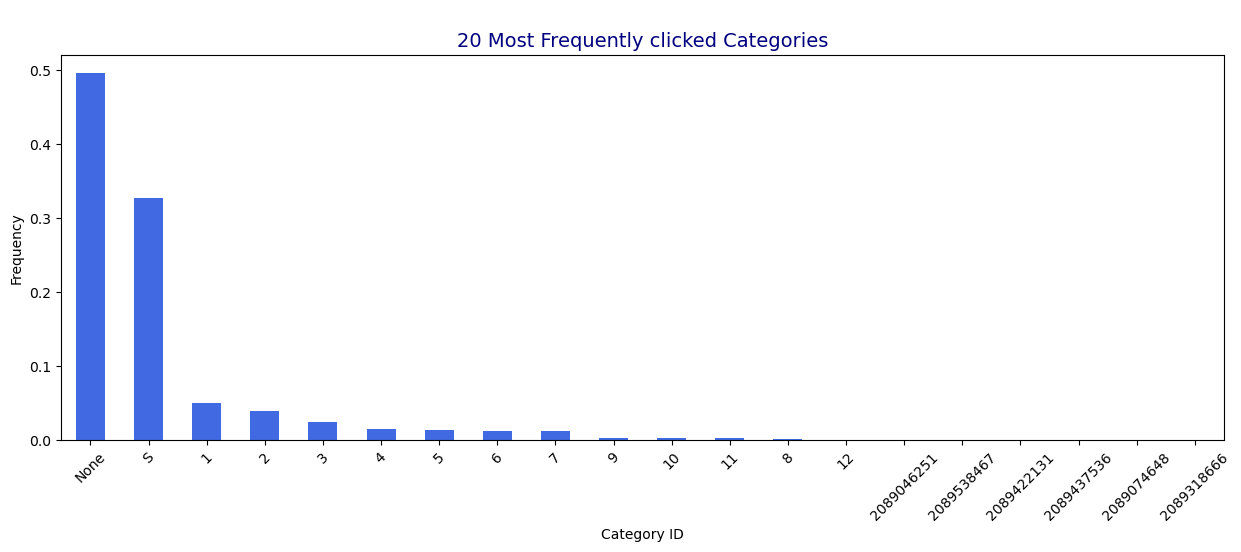

In [3]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Most Frequent categories ids
plt.figure(figsize=(15, 5))

# Top 20 most frequent categories
categories_frequency = stream_df['category'].value_counts().sort_values(ascending=False)[:20]
categories_frequency = categories_frequency/stream_df.shape[0]
categories_frequency.plot(kind='bar', color='royalblue')

# Graph params
plt.title('\n20 Most Frequently clicked Categories', color='navy', size=14)
plt.xlabel('Category ID')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

We see that all brand searches are a very small proportion of the clicks. Therefore, we will bundle them together for the time being. Anything with more than 3 characters will be bundled as "brand search". Let's see how the actual purchases behave relative to the categories browsed, again a item with special offers are more frequently purchased.

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_18592\1961502106.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  stream_df['category'] = stream_df['category'].str.replace(r'\b[\w\s]{5,}\b', 'brand_search')


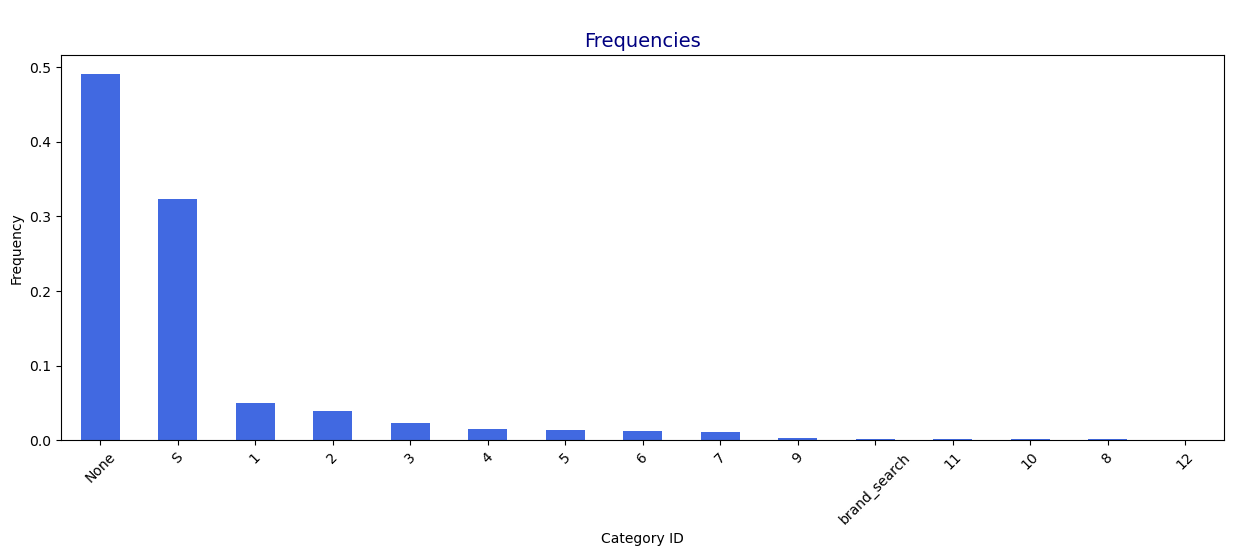

In [4]:
stream_df['category'] = clicks_df['category'].astype(str)

stream_df['category'] = stream_df['category'].str.replace(r'\b[\w\s]{5,}\b', 'brand_search')

plt.figure(figsize=(15, 5))

# Plot of frequencies
categories_frequency = stream_df['category'].value_counts().sort_values(ascending=False)
categories_frequency = categories_frequency/stream_df.shape[0]
categories_frequency.plot(kind='bar', color='royalblue')


plt.title('\nFrequencies', color='navy', size=14)
plt.xlabel('Category ID')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()


Let's see how the actual purchases behave relative to the categories browsed, again a item with special offers are more frequently purchased.

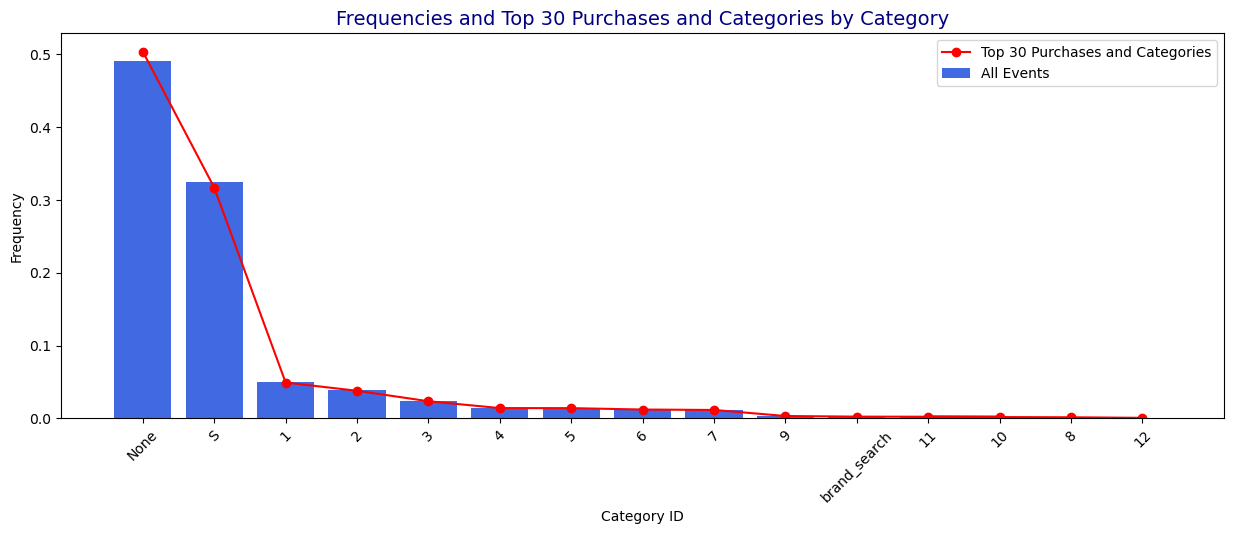

In [5]:
# Plot both frequencies and purchase frequencies
plt.figure(figsize=(15, 5))

clicked_items = stream_df.value_counts('category')/stream_df.shape[0]

# Plot of frequencies as bars
plt.bar(clicked_items.index.astype(str), clicked_items.values, color='royalblue', label='All Events')

purchased_items = stream_df[stream_df['flg_is_purchase']== True].value_counts('category')/stream_df[stream_df['flg_is_purchase']== True].shape[0]

# Plot of purchase frequencies as a line
plt.plot(purchased_items.index.astype(str), purchased_items.values, color='red', marker='o', label='Top 30 Purchases and Categories')

plt.title('Frequencies and Top 30 Purchases and Categories by Category', color='navy', size=14)
plt.xlabel('Category ID')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.legend()
plt.show()



To gain deeper insights into customer browsing behavior, we will analyze the transitions between different item categories and products that users make during their sessions. While the previous visualizations provided a high-level overview, creating a network graph visualization of the click stream data will allow us to examine the specific paths and connections users traverse.

This network visualization will map out the "nodes" that represent individual products or categories, and the "edges" that capture instances where users navigated from one node to another during their browsing journey. It can be seen that users click in many items before they decide to make a purchase.

In [3]:
# Group by session_id and apply shift() within each group
stream_df['next_category'] = stream_df.groupby('session_id')['category'].shift(-1)
stream_df['next_item_id'] = stream_df.groupby('session_id')['item_id'].shift(-1)
stream_df['next_timestamp'] = stream_df.groupby('session_id')['timestamp_click'].shift(-1)

# Calculate time_to_next_click within each group
stream_df['time_to_next_click'] = stream_df.groupby('session_id')['next_timestamp'].diff()

# For the last row within each session_id, set "end" for next_category
stream_df.loc[stream_df.groupby('session_id').tail(1).index, 'next_category'] = 'end'


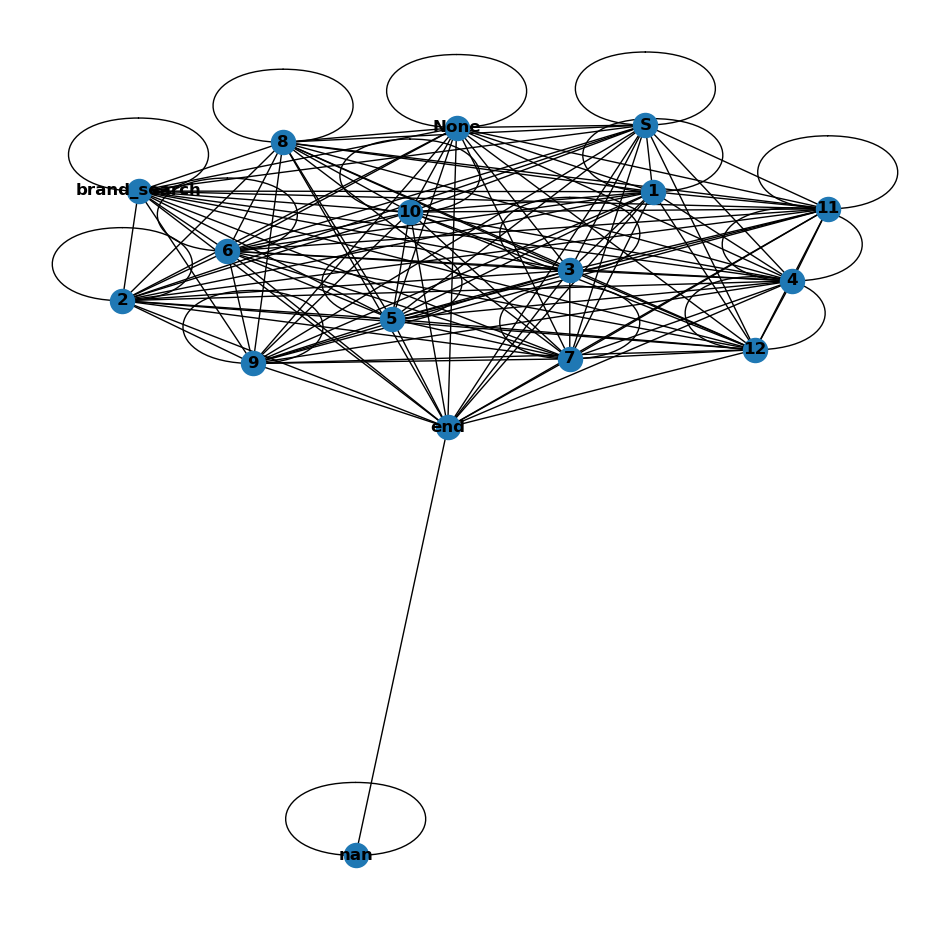

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.from_pandas_edgelist(stream_df, source='category', target='next_category', edge_attr=True)

# Create a list to hold the edges to remove
edges_to_remove = []

# Create new figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Generate layout for the graph
pos = nx.spring_layout(G)

# Draw the graph on the axis
nx.draw(G, pos, with_labels=True, font_weight='bold', ax=ax)

# Show the plot
plt.show()


The other feature we can explore is time of the day. The plot showing the number of clicks per hour reveals two distinct peaks - one around 9am and another around 8pm. These peaks likely correspond to higher traffic volumes during typical morning and evening hours when many customers are browsing the e-commerce site before work/school and after returning home.

Identifying these high-engagement time windows is insightful, as it suggests the time of day could be an influential factor driving click behavior and purchase propensity. Users may exhibit different browsing patterns and intent depending on the hour.

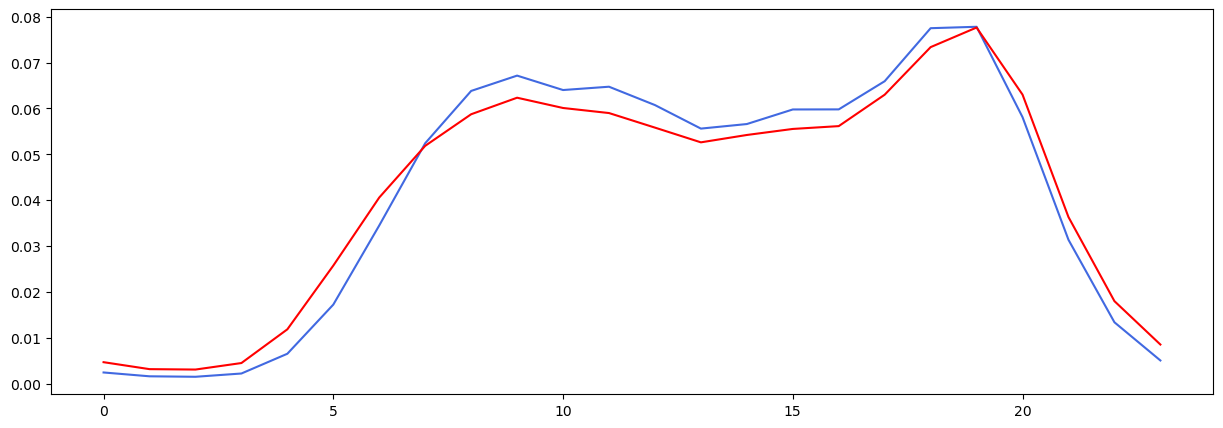

In [8]:
plt.figure(figsize=(15, 5))


# Plot clicks and purchase proportions by hour
buys_hourly_proportions = buys_df['timestamp'].dt.hour.value_counts(normalize=True).sort_index()
clicks_hourly_proportions = clicks_df['timestamp'].dt.hour.value_counts(normalize=True).sort_index()

# plot params
plt.plot(buys_hourly_proportions, color='royalblue')
plt.plot(clicks_hourly_proportions, color='red')
plt.show()


Lastly, we check if there are any any period seasonalities visible, and if this is a relavant feature to train our model. There seems to be a growing trend in the sample we have available. 

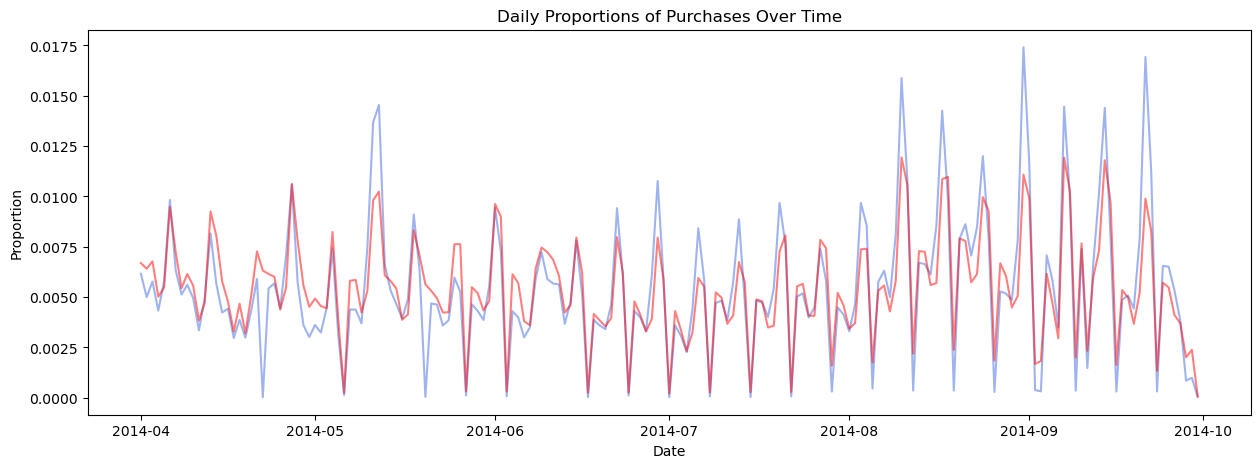

In [9]:
plt.figure(figsize=(15, 5))


buys_daily_proportions = buys_df['timestamp'].dt.date.value_counts(normalize=True).sort_index()
clicks_daily_proportions = clicks_df['timestamp'].dt.date.value_counts(normalize=True).sort_index()

# Plot daily proportions of purchases over time
plt.plot(buys_daily_proportions.index, buys_daily_proportions.values, color='royalblue', alpha=0.5)
plt.plot(clicks_daily_proportions.index, clicks_daily_proportions.values, color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Daily Proportions of Purchases Over Time')
plt.show()



The data exhibits two key temporal patterns - an overall increasing trend in user activity levels, as well as a distinct monthly cyclical pattern with August and September showing higher click volumes. For some reason July, is the lowest month, this could be to seasonal effects, such as holidays during the month of july when a lot of people travel.

However, the limited timeframe makes it challenging to disentangle whether these patterns stem purely from seasonal effects or conflate with long-term business growth.

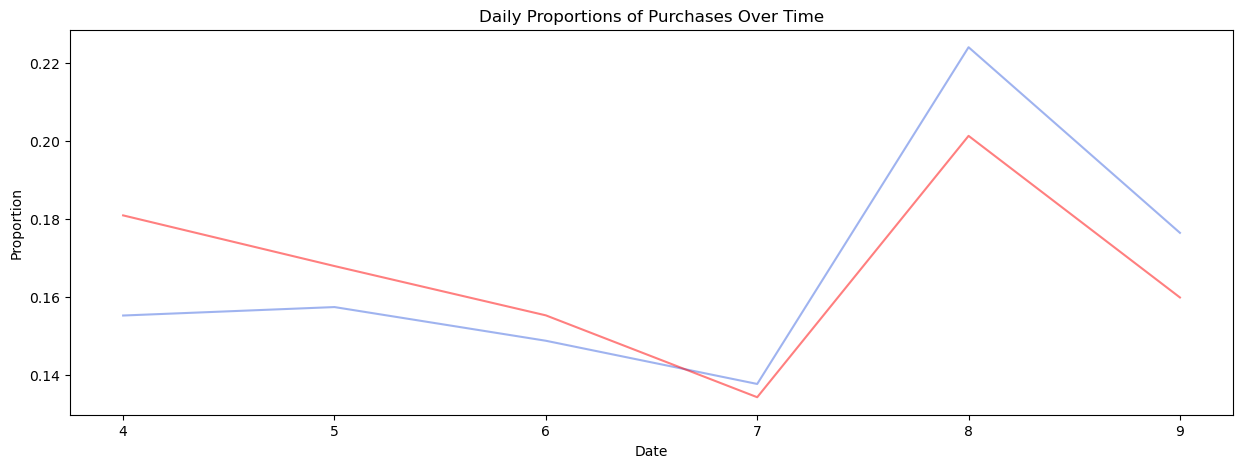

In [15]:
# Check for montly trends

plt.figure(figsize=(15, 5))


buys_monthly_proportions = buys_df['timestamp'].dt.month.value_counts(normalize=True).sort_index()
clicks_monthly_proportions = clicks_df['timestamp'].dt.month.value_counts(normalize=True).sort_index()

# Plot daily proportions of purchases over time
plt.plot(buys_monthly_proportions.index, buys_monthly_proportions.values, color='royalblue', alpha=0.5)
plt.plot(clicks_monthly_proportions.index, clicks_monthly_proportions.values, color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Daily Proportions of Purchases Over Time')
plt.show()


Weekly pattern: There is a clear weekly cyclical pattern in the proportions of purchases. The percentages fluctuate significantly across different days, indicating that purchasing behavior varies based on the day of the week.
Weekend peak: The highest proportion of purchases occurs on Saturday, with Sunday also showing a relatively high percentage compared to weekdays. This suggests that online shopping activity and conversion rates tend to peak over the weekend.

Weekday trough: The proportions of purchases are notably lower from Monday through Thursday, with the lowest point occurring on Tuesday or Wednesday, depending on which line is considered. This indicates that weekdays, particularly mid-week, tend to have lower purchasing levels.

Friday uptick: There is an uptick in the proportion of purchases on Friday compared to earlier weekdays, potentially signaling the start of increased weekend shopping activity.

Upward trend: While the blue and red lines exhibit the same weekly pattern, the red line shows a consistent upward trend over time. This could indicate an overall growth in purchasing activity or a shift in user behavior captured in the data sample.

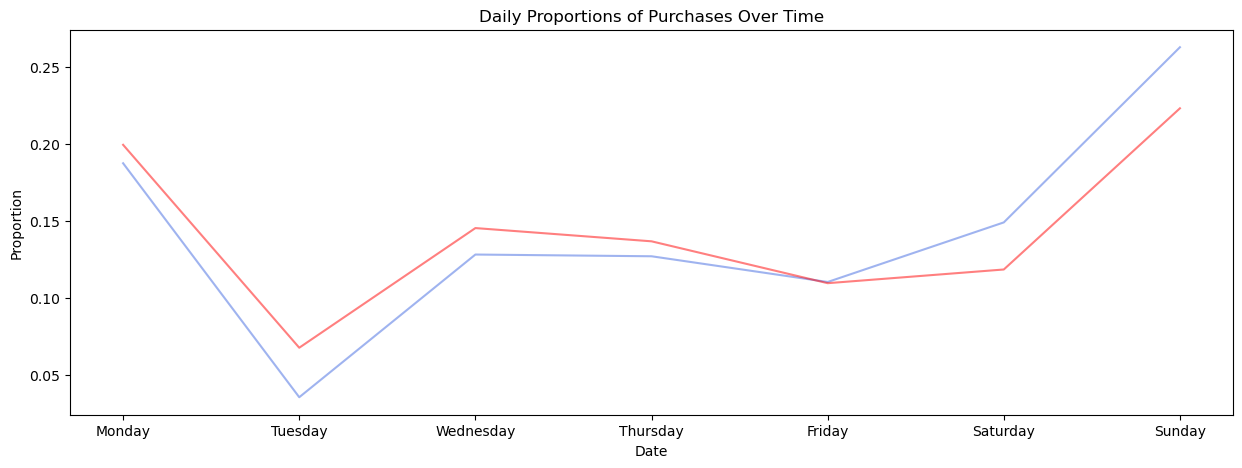

In [27]:
# # Check for weekly trends

plt.figure(figsize=(15, 5))

buys_weekday_proportions = buys_df['timestamp'].dt.weekday.value_counts(normalize=True).sort_index()
clicks_weekday_proportions = clicks_df['timestamp'].dt.weekday.value_counts(normalize=True).sort_index()

# Plot daily proportions of purchases over time
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot daily proportions of purchases over time
plt.plot(days, buys_weekday_proportions.values, color='royalblue', alpha=0.5)
plt.plot(days, clicks_weekday_proportions.values, color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Daily Proportions of Purchases Over Time')
plt.show()


When analysing the data by day of the month, we cannot observe any clear trend.

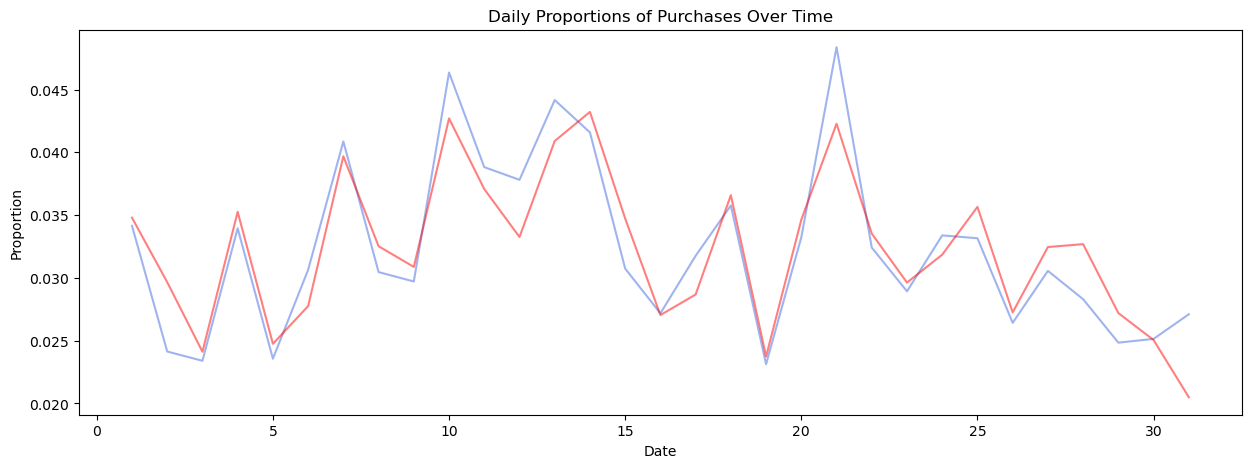

In [35]:
# # Check for monthly trends

plt.figure(figsize=(15, 5))

buys_monthday_proportions = buys_df['timestamp'].dt.day.value_counts(normalize=True).sort_index()
clicks_monthday_proportions = clicks_df['timestamp'].dt.day.value_counts(normalize=True).sort_index()

# Plot daily proportions of purchases over time
#ays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot daily proportions of purchases over time
plt.plot(buys_monthday_proportions.index, buys_monthday_proportions.values, color='royalblue', alpha=0.5)
plt.plot(clicks_monthday_proportions.index, clicks_monthday_proportions.values, color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Daily Proportions of Purchases Over Time')
plt.show()


<br>

<hr style="border: 0.8px dashed #7A7F92;">

<a class="anchor" name="1"></a>




# <span style =  "color:steelblue"> Modelling 

In the following section we will be focusing on the modelling part of the assigment. We will divide the problem in two models: 
- A Binary Classification problem where our goal is to predict if the user will buy or will not buy based on some input features constructed in the feature engineering section. 
- A Recommendation Problem, that derives from the above one, if the algorithm predicts that the user will buy, we will define the possible items that are going to be bought. 

We will split the data set into two: training and test set, to be able to verify the performance of the models with the test set.


<a class="anchor" name="1"></a>




## <span style =  "color:steelblue"> Feature Engineering

 
After understanding the streams and setting up the data, we will need to create the features we will use for the model, particularly for the binary classification problem. The variables were the following

- time_to_purchase: time between first click and purchase time.
- total_session_time: time between first and last timestamps of a session. Passed in seconds to the models.
- unique_categories: number of unique categories explored during session.
- unique_items: number of unique items explored during session.
- session_month: month when the session started.
- session_hour: hour of day when the session started.
- session_weekday: day of the week when the session started.
- num_purchases: number of purchases made during the session. Dropped as input in classification models.
- flg_is_purchase: binary variable indicating if there was a purchase in the session (1 is yes).Dropped as input in classification models.



In [ ]:
sessions.head()

In [28]:
# Create unique sessions dataset
sessions = stream_df.groupby('session_id').size().reset_index(name='count_of_clicks')

# Add total session time
sessions['total_session_time'] = stream_df.groupby('session_id')['timestamp_click'].max().reset_index(drop=True) - stream_df.groupby('session_id')['timestamp_click'].min().reset_index(drop=True)

# Add the number of unique categories
sessions['unique_categories'] = stream_df.groupby('session_id')['category'].nunique()

# Add the number of unique items
sessions['unique_items'] = stream_df.groupby('session_id')['item_id'].nunique()

# Add the clicks per category pivoted to the sessions table
clicks_per_category = stream_df.groupby(['session_id', 'category']).size().unstack(fill_value=0)

# Get min timestamp for each session on the clicks data
stream_df['timestamp_click'].groupby(stream_df['session_id']).min()

# Merge the min timestamp into the sessions dataset
sessions = sessions.merge(stream_df['timestamp_click'].groupby(stream_df['session_id']).min(), on='session_id', how='left')

# Get session month
sessions['session_month'] = sessions['timestamp_click'].dt.month

# Get session hour
sessions['session_hour'] = sessions['timestamp_click'].dt.hour

# Get session weekday
sessions['session_weekday'] = sessions['timestamp_click'].dt.weekday

# Merge the clicks per category into the sessions dataset
sessions = sessions.merge(clicks_per_category, on='session_id', how='left')

# Add number of purchases per session
sessions['num_purchases'] = stream_df.groupby('session_id')['flg_is_purchase'].sum()

# Add if there was a purchase in the session
sessions['flg_is_purchase'] = sessions['num_purchases'] > 0

c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\pandas\core\reshape\reshape.py:126: RuntimeWarning: overflow encountered in long_scalars
  num_cells = num_rows * num_columns


ValueError: negative dimensions are not allowed

## <span style = "color:steelblue"> Binary Classification Problem

Lets now dig into the classification problem.

Our goal will be to predict whether a session will buy or not an item. Therefore, our input data X is a dataset based on sessions, not clicks. Hence, the first thing we need to do is to construct this dataset. Then, the features that comprise X will be determined from what we take from the original datasets. We will train three models to compare its performance and select the best model for this task. The first step is in training the dataset with a very naive approach: Number of clicks and buy probability. For that, we will use three machine learning models to benchmark:

 - Linear regression
 - Decision trees
 - Support Vector Machine


As information becomes available for a given session, we can update our predictions. It makes sense to group the X data per session. If our goal is only to predict (at least in the first part) if there will be a purchase, we don't should not look at the session at any point past the first purchase.

In [ ]:
# Save sessions to a csv file to save time in executing previous code
sessions.to_csv('data/sessions.csv', index=False)

NameError: name 'sessions' is not defined

----------

The next cell is only to skip the previous steps. You don't necessarily need to run it

In [1]:
import pandas as pd

# Load the sessions dataset to start ML code from here 
sessions = pd.read_csv('data/sessions.csv')

# Transform the total session time to timedelta
sessions['total_session_time'] = pd.to_timedelta(sessions['total_session_time'])

We prepare the data to fit our models, splitting input variables from the output variable and fragmenting the data into the traning and test set.

In [2]:
import numpy as np
# Prepare the data for the model
X = sessions.drop(['session_id', 'timestamp_click', 'flg_is_purchase', 'num_purchases'], axis=1)
y = sessions['flg_is_purchase']

# Convert the total session time to seconds
X['total_session_time'] = X['total_session_time'].dt.total_seconds()

# Fill missing values with 0
X.fillna(0, inplace=True)

# Import necessary libraries
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Save the data to csv files to save time in executing previous code
X_train.to_csv('data/X_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)


from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# Defining reusable functions

def roc_auc_curve(y_pred_prob, title, threshold = 0.5):
    # Convert probabilities predictions to binary (0 or 1) based on a threshold
    y_pred_class = (y_pred_prob > threshold).astype(int)
 
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
 
    # Plot ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def cm_print(X_test, y_test, model, title='Confusion Matrix on Test Data'):
    # Print confusion matrix, given the X_test, y_test and the model
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()


## <span style = "color:darkblue"> Logistic Regression

<span style = "color:red"> Explain what is does the algorithm do and comment on the performance and its meaning

c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Model
Accuracy: 0.9548120143326706
Precision: 0.25572405590246805
Recall: 0.006949494949494949
F1 Score: 0.013531267454941667


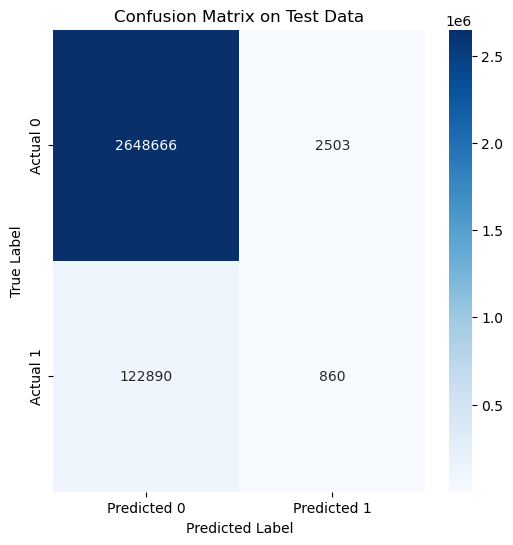

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import standard scaler from sklearn
from sklearn.preprocessing import StandardScaler

# Create a logistic regression model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train, y_train)

log_reg_preds = log_reg.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 scores
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
log_reg_precision = precision_score(y_test, log_reg_preds)
log_reg_recall = recall_score(y_test, log_reg_preds)
log_reg_f1 = f1_score(y_test, log_reg_preds)

# Print the results
print('Logistic Regression Model')
print('Accuracy: {}'.format(log_reg_accuracy))
print('Precision: {}'.format(log_reg_precision))
print('Recall: {}'.format(log_reg_recall))
print('F1 Score: {}'.format(log_reg_f1))

cm_print(X_test, y_test, log_reg, title='Confusion Matrix on Test Data')

Next, we need to apply the Z-score normalization. We will use sklearn's built in package for that: StandardScaler, which applies the following formula: $\frac{x-\hat{\mu}}{s}$, where $\hat{\mu}$ is the sample mean and the $s$ is the sample standard deviation

c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Model
Accuracy: 0.9545954314342149
Precision: 0.25308098591549294
Recall: 0.009292929292929294
F1 Score: 0.017927572606669058


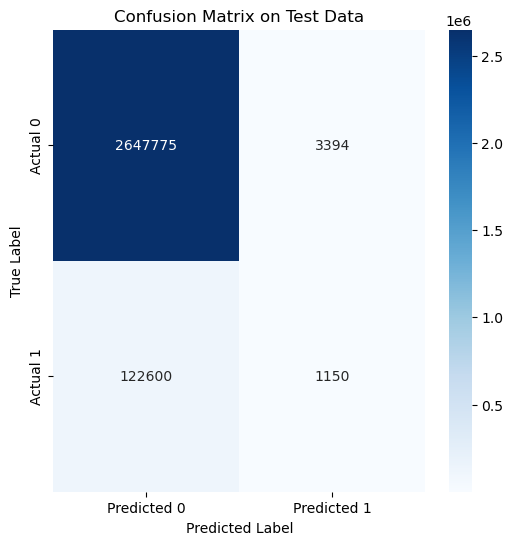

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import standard scaler from sklearn
from sklearn.preprocessing import StandardScaler

# Create a logistic regression model
log_reg = LogisticRegression()

# Create a standard scaler
scaler = StandardScaler()

# Select numerical columns to scale
num_cols = ['count_of_clicks', 'total_session_time', 'unique_categories', 'unique_items']

# Fit the scaler on the training data
scaler.fit(X_train[num_cols])

# Transform the training data
X_train[num_cols] = scaler.transform(X_train[num_cols])

# Transform the testing data
X_test[num_cols] = scaler.transform(X_test[num_cols])


# Fit the model
log_reg.fit(X_train, y_train)

log_reg_preds = log_reg.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 scores
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
log_reg_precision = precision_score(y_test, log_reg_preds)
log_reg_recall = recall_score(y_test, log_reg_preds)
log_reg_f1 = f1_score(y_test, log_reg_preds)

# Print the results
print('Logistic Regression Model')
print('Accuracy: {}'.format(log_reg_accuracy))
print('Precision: {}'.format(log_reg_precision))
print('Recall: {}'.format(log_reg_recall))
print('F1 Score: {}'.format(log_reg_f1))

cm_print(X_test, y_test, log_reg, title='Confusion Matrix on Test Data')


For the out-of the box logistic regression model, we achieved over 90% accuracy, which is unimpressive, given the distribution of the target label. However, it shows a lot of promise, specially as we improve the model's performance by applying hyper-parameter tuning. For computational feasibility, we used Randomized search for hyper-parameter tuning. We could have instantiated cloud resources to enable multi-core processing, but we believed it to be outside the scope of this assignment. 

c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 42 is smaller than n_iter=100. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 42 candidates, totalling 210 fits


c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tuned Logistic Regression Parameters: {'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.1}
Tuned Logistic Regression Model
Accuracy: 0.6763678507372648
Precision: 0.07688036957659786
Recall: 0.5684444444444444
F1 Score: 0.135442549312005


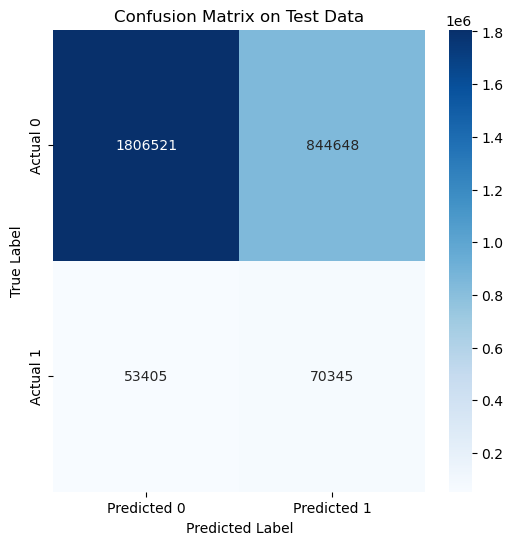

In [14]:
# Tune hyperparameters with GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create a dictionary of hyperparameters to search. We will try a range of C penalization scores. We will try L1, L2 and None. For this reason, we need to change the solver to 'saga'. We will also try balanced and None for class_weight.
grid = {'C': np.logspace(-3,3,7), 'class_weight': ['balanced', None], 'penalty': ['l1', 'l2', None], 'solver': ['saga']}

# Create randomized search 10-fold cross validation and 100 iterations
log_reg_cv = RandomizedSearchCV(log_reg, grid, cv=5, n_iter=100, scoring='recall', random_state=42, verbose=1, n_jobs=-1)

# Fit the model
log_reg_cv.fit(X_train, y_train)

# Print the best hyperparameters
print("Tuned Logistic Regression Parameters: {}".format(log_reg_cv.best_params_))

# Print the accuracy after hyperparameter tuning

log_reg_cv_preds = log_reg_cv.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 scores
log_reg_cv_accuracy = accuracy_score(y_test, log_reg_cv_preds)
log_reg_cv_precision = precision_score(y_test, log_reg_cv_preds)
log_reg_cv_recall = recall_score(y_test, log_reg_cv_preds)
log_reg_cv_f1 = f1_score(y_test, log_reg_cv_preds)

# Print the results
print('Tuned Logistic Regression Model')
print('Accuracy: {}'.format(log_reg_cv_accuracy))
print('Precision: {}'.format(log_reg_cv_precision))
print('Recall: {}'.format(log_reg_cv_recall))
print('F1 Score: {}'.format(log_reg_cv_f1))

cm_print(X_test, y_test, log_reg_cv, title='Confusion Matrix on Test Data')

In [15]:
# Save the numpy predictions to disk
np.save('results/log_reg_cv_preds.npy', log_reg_cv_preds)

# Save best model of the grid search to disk
import joblib
joblib.dump(log_reg_cv, 'results/log_reg_cv_model.pkl')

# Print the best hyperparameters
print("Tuned Logistic Regression Parameters: {}".format(log_reg_cv.best_params_))

Tuned Logistic Regression Parameters: {'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.1}


## <span style = "color:darkblue"> Random Forest Model

c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Model
Accuracy: 0.9554041036873508
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


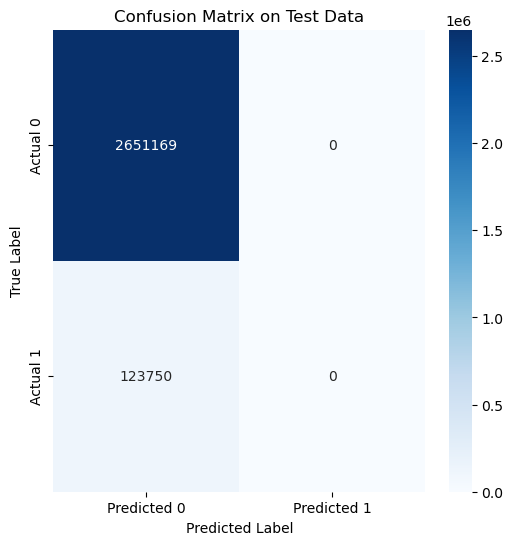

In [16]:
# Random forest model

from sklearn.ensemble import RandomForestClassifier

# Create a random forest model with common good hyperparameters and low number of estimators to save time
rf = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, class_weight=None)

# Fit the model
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 scores
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)

# Print the results
print('Random Forest Model')
print('Accuracy: {}'.format(rf_accuracy))
print('Precision: {}'.format(rf_precision))
print('Recall: {}'.format(rf_recall))
print('F1 Score: {}'.format(rf_f1))

cm_print(X_test, y_test, rf, title='Confusion Matrix on Test Data')

Checking the results, we see that the random forest model shows more / less promise than the regression model. Therefore, we will Not continue with hyper-parameter tuning to save time.

## <span style = "color:darkblue"> Support Vector Machine

,count_of_clicks,total_session_time,unique_categories,unique_items,session_month,session_hour,1,10,11,12,...,3,4,5,6,7,8,9,None,S,brand_search
4718039,-0.410327,-0.176601,0.016343,0.578545,7,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7999173,1.136346,0.317060,0.016343,-0.111527,9,18,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
1838140,-0.410327,-0.501486,-1.354107,-0.801600,5,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4403899,3.714133,3.314770,0.016343,-0.111527,6,10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,14.0,0.0
1956548,0.620788,2.259027,0.016343,-0.111527,5,17,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7204212,0.878567,-0.076694,1.386794,-0.111527,8,7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
2234489,1.136346,0.459795,0.016343,-0.111527,5,21,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
4304572,2.425239,0.398391,0.016343,-0.111527,6,8,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
6550634,0.105231,-0.343530,0.016343,0.233509,8,7,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import standard scaler from sklearn
from sklearn.preprocessing import StandardScaler

# Create a standard scaler
scaler = StandardScaler()

# Select numerical columns to scale
num_cols = ['count_of_clicks', 'total_session_time', 'unique_categories', 'unique_items']

# Fit the scaler on the training data
scaler.fit(X_train[num_cols])

# Transform the training data
X_train[num_cols] = scaler.transform(X_train[num_cols])

# Transform the testing data
X_test[num_cols] = scaler.transform(X_test[num_cols])

c:\Users\Bernardo Carvalho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Model
Accuracy: 0.9554041036873508
Precision: 0.0
Recall: 0.0


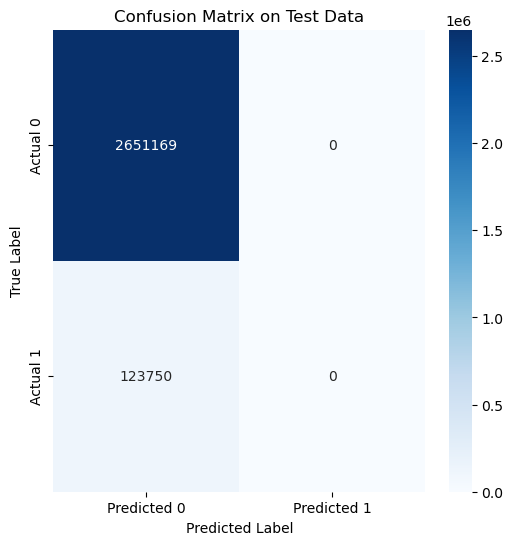

In [6]:
# Train the SVM model
from sklearn.svm import SVC

# Create a support vector machine model
svm = SVC()

# Fit the model
svm.fit(X_train[:20000], y_train[:20000])

svm_preds = svm.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 scores
svm_accuracy = accuracy_score(y_test, svm_preds)
svm_precision = precision_score(y_test, svm_preds)
svm_recall = recall_score(y_test, svm_preds)
svm_f1 = f1_score(y_test, svm_preds)

# Print the results
print('SVM Model')
print('Accuracy: {}'.format(svm_accuracy))
print('Precision: {}'.format(svm_precision))
print('Recall: {}'.format(svm_recall))

cm_print(X_test, y_test, svm, title='Confusion Matrix on Test Data')

**Features to create and investigate**

Come up with some segments upfront and see if we can identify them

1. Time since last click
2. Clicks per minute


Check item click occurance and buy occurence of items (to see if some bundling is necessary)

<br>

<hr style="border: 0.2px dashed #7A7F92;">

## <span style = "color:steelblue"> Recommendation Problem

After predicting which users will make a purchase, the next step is to determine what specific items they will buy. This can be achieved by applying collaborative filtering techniques to build a recommendation model. The recommendation system will serve as a proxy for predicting the actual items a user will purchase during their session.


In [18]:
# Skip this cell if you have already run the previous cells

import pandas as pd

sessions = pd.read_csv('data/sessions.csv')

# CHANGE THIS TO THE DATA PATH ON YOUR COMPUTER
path = 'data/'

# Import click file
clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'category'])

# Import buy file
buys_df = pd.read_csv(path + 'yoochoose-buys.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'price', 'quantity'])

# Convert timestamp to datetime
clicks_df['timestamp'] = pd.to_datetime(clicks_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Sort the clicks data by session_id and timestamp
clicks_df.sort_values(['session_id','timestamp'], inplace=True)

# Convert timestamp to datetime
buys_df['timestamp'] = pd.to_datetime(buys_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Sort the buys data by session_id and timestamp
buys_df.sort_values(['session_id','timestamp'], inplace=True)

# Clean up the 0 and string 0 values from clicks
clicks_df.replace({'category': {0: 'None', '0': 'None'}}, inplace=True)

# Clean up the 0 and string 0 values from clicks
buys_df.replace({'category': {0: 'None', '0': 'None'}}, inplace=True)

# Create the stream dataset
stream_df = clicks_df.merge(buys_df, on=['session_id', 'item_id'], how='left', suffixes=('_click', '_buy'))  

# Calculate the time to purchase
stream_df['time_to_purchase'] = stream_df['timestamp_buy'] - stream_df['timestamp_click']

# Create flag to mark the purchases that were actually made
stream_df['flg_is_purchase'] = stream_df['timestamp_buy'].notnull()

# Drop unnecessary columns
stream_df.drop(['timestamp_buy', 'price', 'quantity'], axis=1, inplace=True)

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_1372\378423381.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  clicks_df = pd.read_csv(path + 'yoochoose-clicks.dat', header=None, names=['session_id', 'timestamp', 'item_id', 'category'])


We can't simply build the utility matrix using pandas, since it won't fit the memory of the computer. Instead, we will need to build a sparse matrix using 

In [23]:
from scipy.sparse import csr_matrix
import numpy as np

# Real dataset to run the method. Keep only records that were in the training set X_train
data = stream_df[stream_df['session_id'].isin(X_train.index.to_list())]

# Create a dictionary to map session_id and item_id to integer indices
session_to_index = {session_id: i for i, session_id in enumerate(data['session_id'].unique())}
item_to_index = {item_id: i for i, item_id in enumerate(data['item_id'].unique())}

# Map session_id and item_id to integer indices
data['session_index'] = data['session_id'].map(session_to_index)
data['item_index'] = data['item_id'].map(item_to_index)

# Create sparse matrix
num_sessions = len(session_to_index)
num_items = len(item_to_index)
data_length = len(data)
data_ones = np.ones(data_length)
row = data['session_index']
col = data['item_index']
utility_matrix_sparse = csr_matrix((data_ones, (row, col)), shape=(num_sessions, num_items))

# save the utility matrix to disk
from scipy.sparse import save_npz

save_npz('results/utility_matrix_sparse.npz', utility_matrix_sparse)

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_1372\1335725097.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['session_index'] = data['session_id'].map(session_to_index)
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_1372\1335725097.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['item_index'] = data['item_id'].map(item_to_index)


Now we apply the similarity function to our utility matrix. For simplicity, we will use cosine_similatiry from the metrics package of sklearn

In [24]:
# Building the similarity function for the sparse matrix utility_matrix_sparse
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity
item_similarity = cosine_similarity(utility_matrix_sparse.T)

# Create a DataFrame
item_similarity_df = pd.DataFrame(item_similarity, index=item_to_index.keys(), columns=item_to_index.keys())

# Save the item similarity to disk
item_similarity_df.to_csv('results/item_similarity.csv')

KeyboardInterrupt: 

    Next, we start building our function that takes a session from the test set, finds the most similar sessions and ranks them 

In [21]:
# Load the utility matrix from disk
from scipy.sparse import load_npz

utility_matrix_sparse = load_npz('results/utility_matrix_sparse.npz')

# Load log_reg_cv_preds from disk
log_reg_cv_preds = np.load('results/log_reg_cv_preds.npy')

In [19]:
# Building the recommendation function that takes an item and returns the most similar items

def get_similar_items(item_id, item_similarity_df, similarity_threshold=0.1):
    # Get the similarity values for the item
    similar_items = item_similarity_df.loc[item_id]
    
    # Sort the items by similarity
    similar_items = similar_items.sort_values(ascending=False)

    # remove the item itself
    similar_items = similar_items.drop(item_id)

    # remove items with similarity 0
    similar_items = similar_items[similar_items > 0]

    # remove items with similarity below the threshold
    similar_items = similar_items[similar_items > similarity_threshold]

    return similar_items

Applying the performance metric, defined as:

In [ ]:
# Test data for the time being, substitute this with the final predictions
submitted_data = data
test_data = stream_df[stream_df['session_id'].isin(X_test.index.to_list())]

def performance_score(submitted_data, test_data):
    # Instantiate the total score
    total_score = 0

    # Calculate the fixed reward (for each purchase, the reward is 1/total number of purchases in the test data)
    fixed_reward = test_data['flg_is_purchase'].sum() / len(test_data['flg_is_purchase'])

    # Sessions in test set that are actually a buy
    S_b = test_data[test_data['flg_is_purchase'] == True]['session_id'].unique()

    for session_id, session in submitted_data.iterrows():

        B_s = test_data[test_data['session_id'] == session_id]['item_id'].unique().tolist()
        A_s = session['similar_items']

        # Get intersection of A_s and B_s
        intersection = list(set(A_s) & set(B_s))
        # Get union of A_s and B_s
        union = list(set(A_s) | set(B_s))
        # Calculate the Jaccard similarity
        jaccard_similarity = len(intersection) / len(union)

        if session_id in S_b:
            total_score += fixed_reward + jaccard_similarity
        else:
            total_score -= fixed_reward
    return total_score

performance_score(submitted_data, test_data)


88.55690467349078

In [ ]:
# Instantiate a list to hold the performances
performances = []

thresholds = np.linspace(0, 1, 10)

for threshold in thresholds:  # Convert range arguments to integers
    # Apply the get_similar_items function to the last item in each session, removing the ones already in all_items
    data['similar_items'] = data['last_item_id'].apply(lambda x: get_similar_items(x, item_similarity_df, threshold).index.difference(data['all_items'].explode()).tolist())
    performances.append(performance_score(data, test_data))

C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_22060\3468273505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['similar_items'] = data['last_item_id'].apply(lambda x: get_similar_items(x, item_similarity_df, threshold).index.difference(data['all_items'].explode()).tolist())
C:\Users\Bernardo Carvalho\AppData\Local\Temp\ipykernel_22060\3468273505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['similar_items'] = data['last_item_id'].apply(lambda x: get_similar_items(x, item_simila

We could potentially add some thoughts about deploying this model to production eventually (quite heavy)

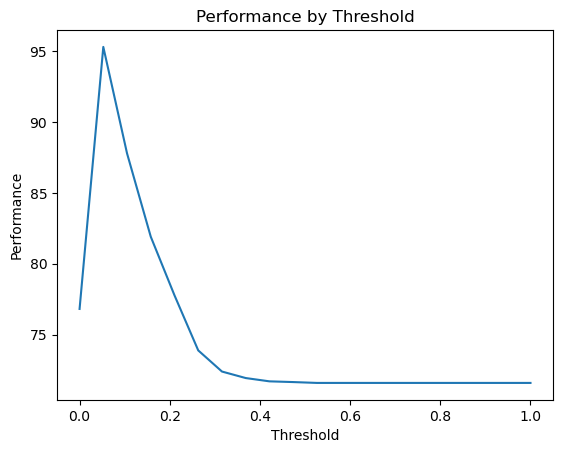

In [ ]:
import matplotlib.pyplot as plt

# Plot the performances
plt.plot(thresholds, performances)

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.title('Performance by Threshold')

# Show the plot
plt.show()

In [88]:
S_b = len(test_data[test_data['flg_is_purchase'] == True]['session_id'].unique())
S = len(test_data['session_id'].unique())


S_b + S_b**2/S

S_b

123750

<br>

<hr style="border: 0.8px dashed #7A7F92;">